In [34]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import torch.nn.functional as F
import torch.nn.init as init

# use GPU if available for faster training times
if torch.cuda.is_available():
    device = torch.device("cuda")
    print('Using GPU')
elif torch.mps.is_available():
    device = torch.device("mps")
    print('Using MPS')
else:
    device = torch.device("cpu")
    print('Using CPU')


Using MPS


# Load all the data

In [ ]:
# ! gdown https://drive.google.com/uc?id=1LK65H6dtv34R_evtIHZGFPJlvCDFdWA7 -O data.hdf5
# ! gdown https://drive.google.com/uc?id=1p0QrCMYTlWaHjo-XxZvp1d704RlENhgU -O trained_model_weights.pth

In [ ]:
ds = xr.open_dataset('/Users/jools/Documents/UCL/ARIEL/ariel_project_code/DATA/simulated_exoplanet_atmospheres_more_mols.hdf5')

spectra = ds['spectra'].values
print(spectra.shape)

# Use numpy.isnan to check for NaN values
nan_count = np.isnan(spectra).sum()
print(f"Number of NaN values: {nan_count}")

# Remove NaN values by replacing them with 0
spectra = np.nan_to_num(spectra)
print(spectra.shape)


def min_max_normaliser(x, dim=None):
    '''normalises the input np array to the range [0, 1]'''

    x = np.array(x)
    x_min = np.min(x, axis=dim, keepdims=True)
    x_max = np.max(x, axis=dim, keepdims=True)

    x = (x-x_min)/(x_max-x_min + np.finfo(float).eps)

    return x

ds

(30000, 52)
Number of NaN values: 13364
(30000, 52)


<xarray.Dataset> Size: 18MB
Dimensions:             (samples: 30000, molecules: 10, wavelength: 52)
Coordinates:
  * samples             (samples) int64 240kB 0 1 2 3 ... 29997 29998 29999
  * molecules           (molecules) <U10 400B 'PH3' 'P2H2_cis' ... 'CO' 'CH4'
  * wavelength          (wavelength) float64 416B 0.55 0.7 0.95 ... 6.814 7.276
Data variables:
    log_abundance       (samples, molecules) float64 2MB ...
    star_temperature    (samples) int64 240kB ...
    star_radius         (samples) float64 240kB ...
    planet_mass         (samples) float64 240kB ...
    planet_radius       (samples) float64 240kB ...
    planet_temperature  (samples) float64 240kB ...
    planet_distance     (samples) float64 240kB ...
    stellar_class       (samples) <U1 120kB ...
    planet_class        (samples) <U15 2MB ...
    spectra             (samples, wavelength) float64 12MB 0.01328 ... 0.0

## Spectra Plot

Text(0, 0.5, 'Tranit Depth (%)')

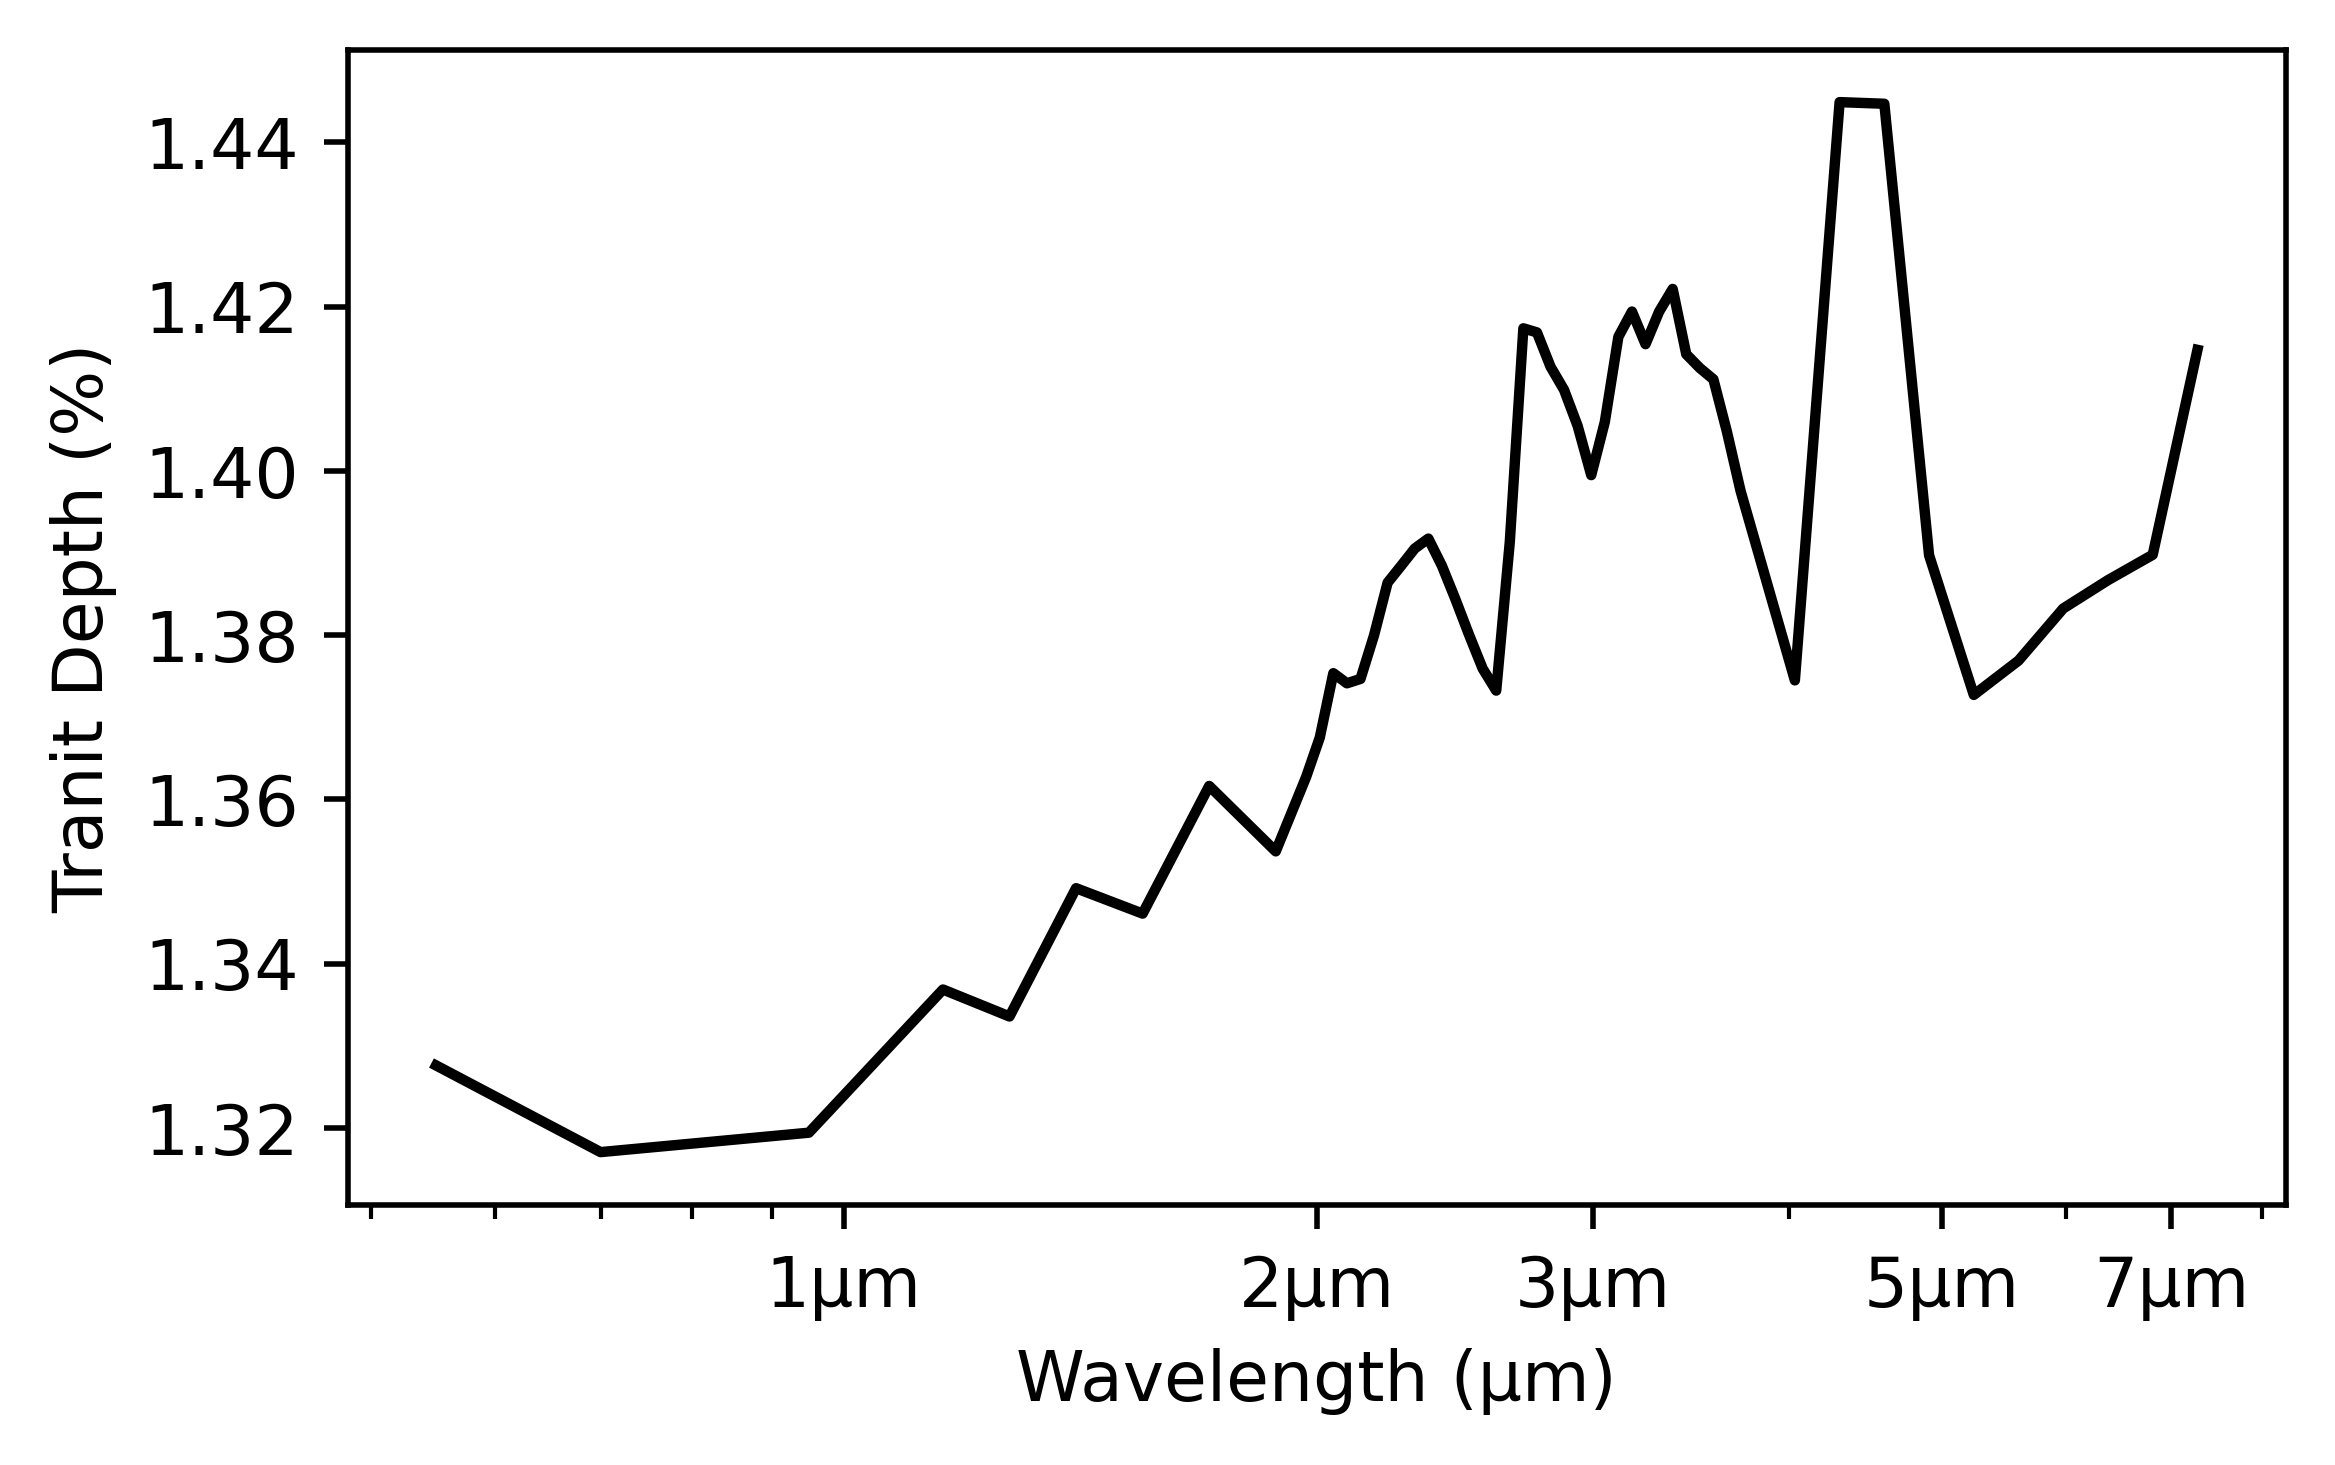

In [37]:
plt.figure(figsize=(5, 3), dpi=500)
plt.plot(ds['wavelength'], spectra[0]*100, color='black') # Plot the first spectrum, the 0 here means the first, so we can change that to 1 to plot the second, or 2 for the 3rd etc
plt.xscale('log')
plt.xticks([1, 2, 3, 5, 7], ['1µm', '2µm', '3µm', '5µm', '7µm'])
plt.xlabel('Wavelength (µm)')
plt.ylabel('Tranit Depth (%)')


## Multiple Spectra Plot

Text(0, 0.5, 'Tranit Depth (%)')

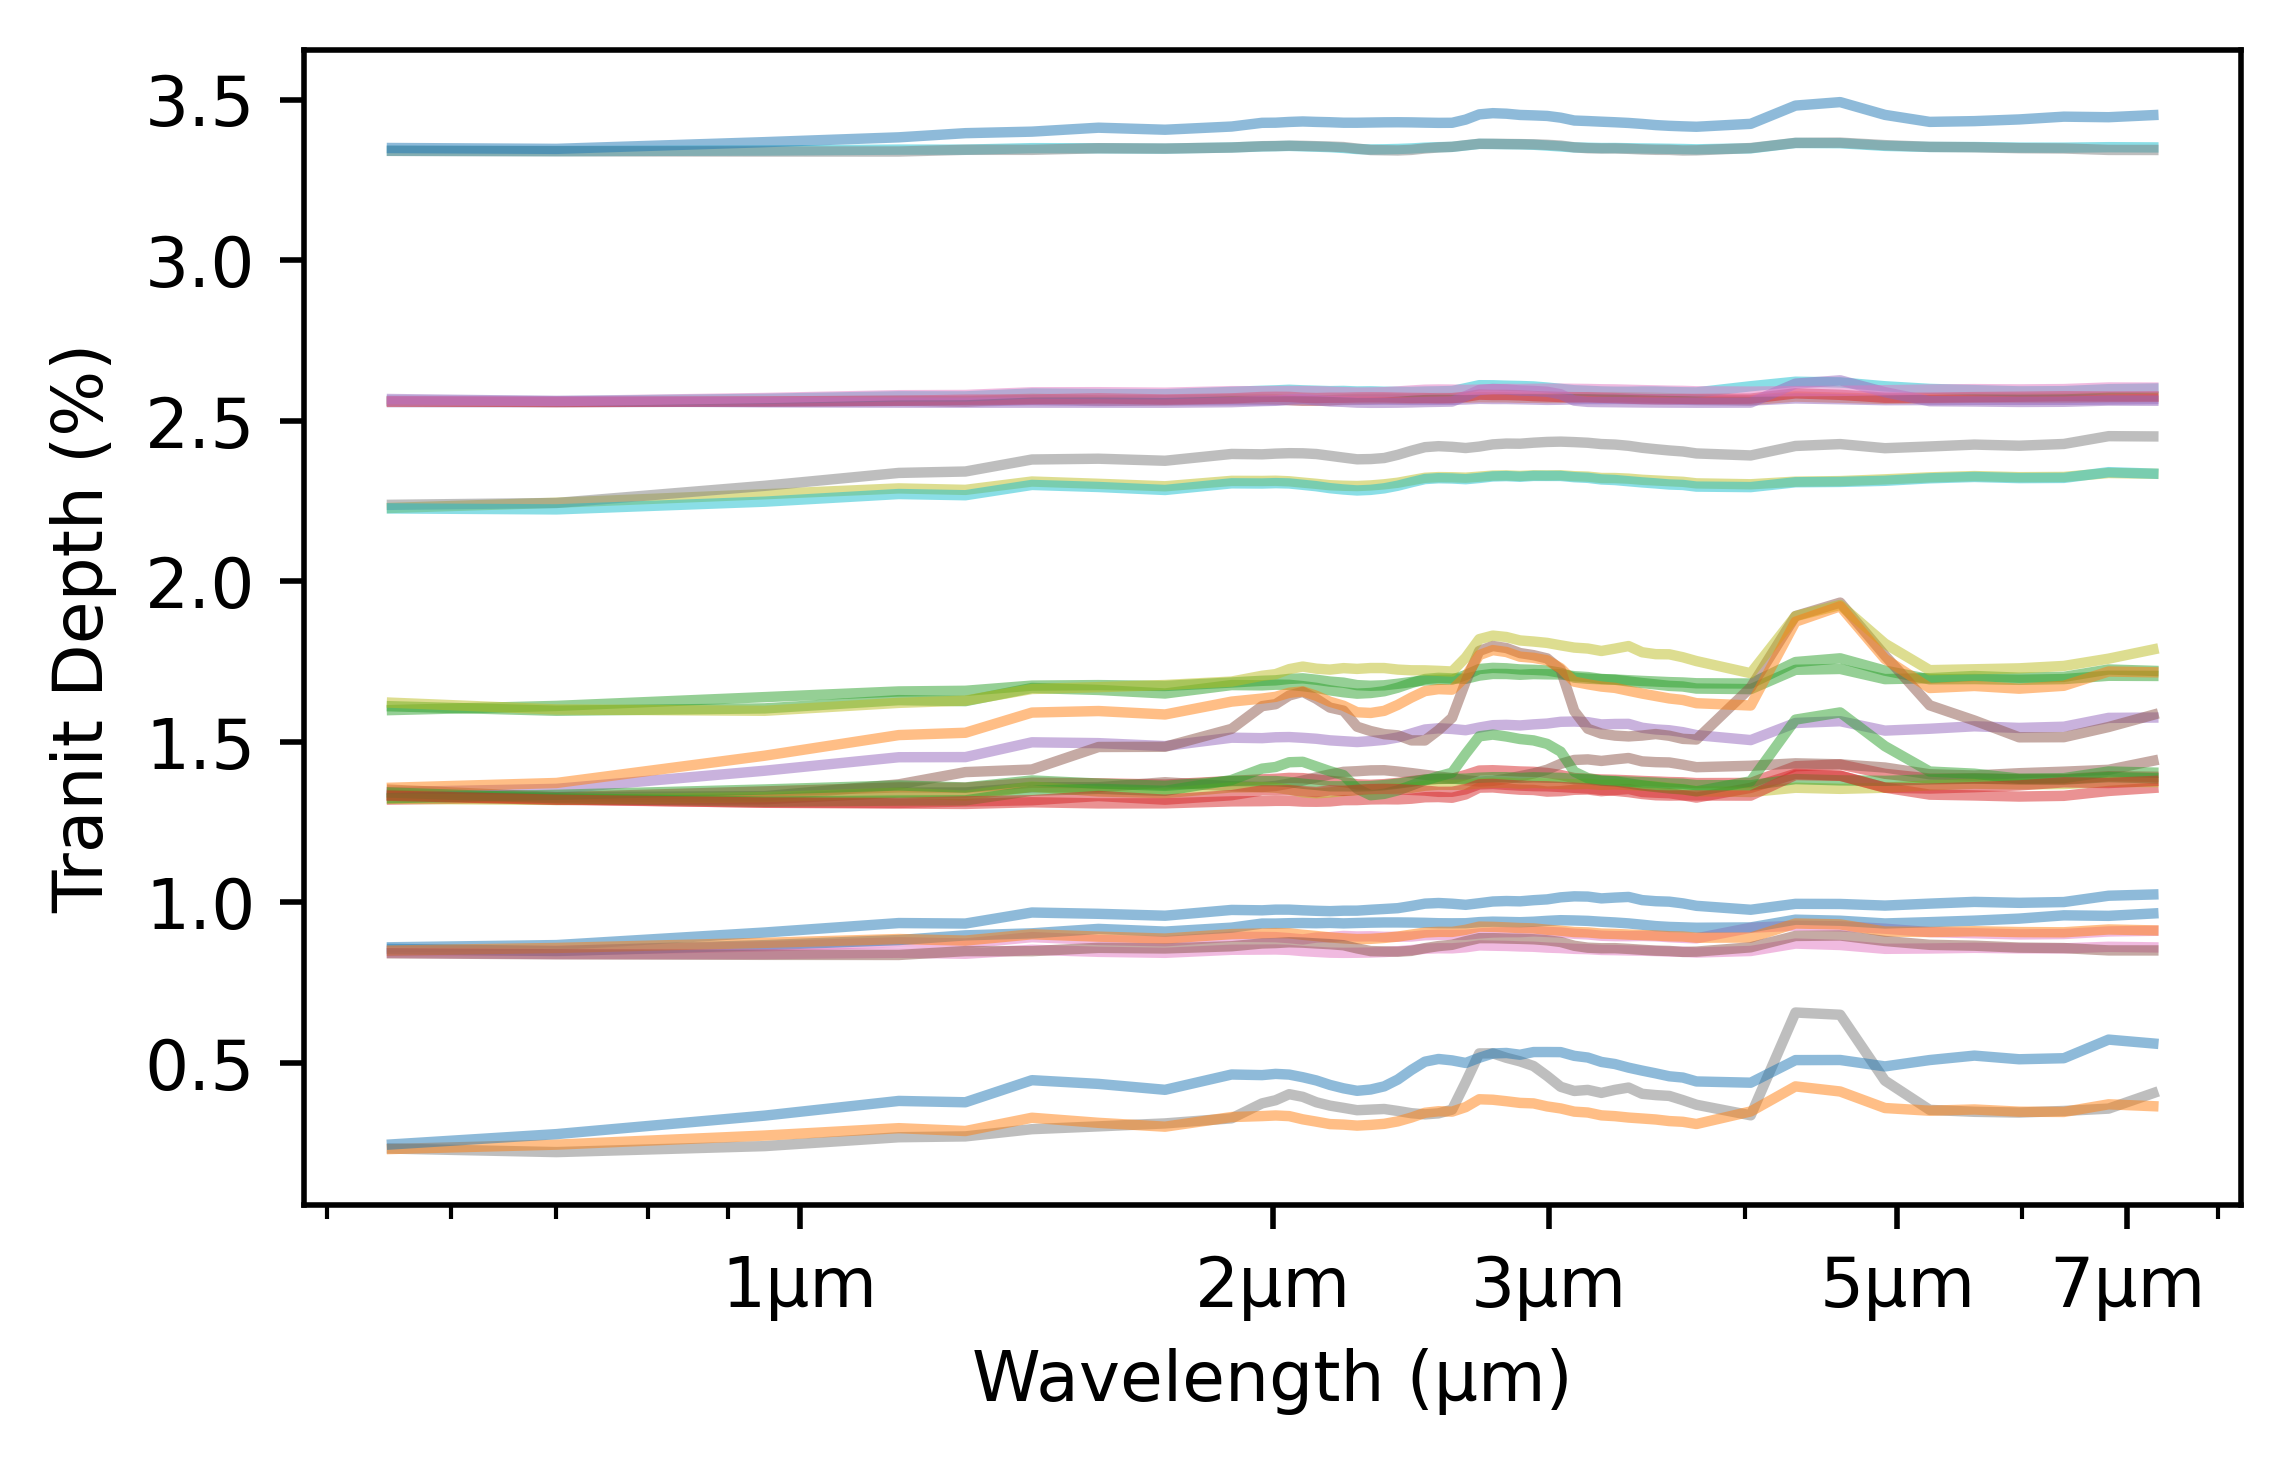

In [38]:
plt.figure(figsize=(5, 3), dpi=500)
for i in range(1, 35): # Loop through the first 35 spectra
    plt.plot(ds['wavelength'], spectra[i]*100, alpha=0.5) # Plot the spectra with a different colour, and a little transparency, this is what alpha=0.5 does. alpha=1 is fully opaque, and alpha=0 is fully transparent
plt.xscale('log')
plt.xticks([1, 2, 3, 5, 7], ['1µm', '2µm', '3µm', '5µm', '7µm'])
plt.xlabel('Wavelength (µm)')
plt.ylabel('Tranit Depth (%)')

# Load in the model, and create the model predictions

In [39]:
included_molecules = ['H2O', 'CH4']

In [40]:
mol_header = ds['molecules'].values
chemical_abundances = ds['log_abundance'].values

print(mol_header)
print(chemical_abundances.shape)


index = np.isin(mol_header, included_molecules)

labels = chemical_abundances[:, index]
labels.shape

# split train into train and test - we will use the test data to evaluate the model

tts = [0.8, 0.2] # 80% train, 20% test
seed = 42 # random seed for reproducibility
train_spectra, test_spectra, train_labels, test_labels = train_test_split(
    min_max_normaliser(spectra, dim=1), # here we input the regular spectra, but we should probably use the normalised spectra
    labels,
    test_size=tts[1],
    random_state=seed)

# print shapes in table
print(f"""
train_spectra: {train_spectra.shape}
train_labels: {train_labels.shape}

test_spectra: {test_spectra.shape}
test_labels: {test_labels.shape}
""")

['PH3' 'P2H2_cis' 'P2H2_trans' 'O2' 'NH3' 'N2' 'H2O' 'CO2' 'CO' 'CH4']
(30000, 10)

train_spectra: (24000, 52)
train_labels: (24000, 2)

test_spectra: (6000, 52)
test_labels: (6000, 2)



In [41]:
class ImprovedDeeperModel(nn.Module):
    def __init__(self):
        super(ImprovedDeeperModel, self).__init__()
        self.shortcut_proj = nn.Linear(1024, 512)

        self.fc1 = nn.Linear(52, 1024)
        self.bn1 = nn.BatchNorm1d(1024)
        self.dropout1 = nn.Dropout(0.05)

        self.fc2 = nn.Linear(1024, 768)
        self.bn2 = nn.BatchNorm1d(768)
        self.dropout2 = nn.Dropout(0.05)

        self.fc3 = nn.Linear(768, 512)
        self.bn3 = nn.BatchNorm1d(512)
        self.dropout3 = nn.Dropout(0.1)  # <- middle dropout a bit higher

        self.fc4 = nn.Linear(512, 384)
        self.bn4 = nn.BatchNorm1d(384)
        self.dropout4 = nn.Dropout(0.1)

        self.fc5 = nn.Linear(384, 256)
        self.bn5 = nn.BatchNorm1d(256)
        self.dropout5 = nn.Dropout(0.1)

        self.fc6 = nn.Linear(256, 128)
        self.bn6 = nn.BatchNorm1d(128)
        self.dropout6 = nn.Dropout(0.05)  # -> slightly lower again

        self.fc7 = nn.Linear(128, 64)
        self.bn7 = nn.BatchNorm1d(64)
        self.dropout7 = nn.Dropout(0.05)

        self.fc8 = nn.Linear(64, 32)
        self.bn8 = nn.BatchNorm1d(32)
        self.dropout8 = nn.Dropout(0.05)

        self.fc9 = nn.Linear(32, 2) #1) #CHANGED THIS 1 TO A 2 as you are predicting on TWO species 

        self._initialize_weights()

    def forward(self, x):
        # Forward pass with optional tiny residual skip after first 3 layers
        x1 = F.silu(self.bn1(self.fc1(x)))
        x1 = self.dropout1(x1)

        x2 = F.silu(self.bn2(self.fc2(x1)))
        x2 = self.dropout2(x2)

        x3 = F.silu(self.bn3(self.fc3(x2)))
        x3 = self.dropout3(x3)

        shortcut = self.shortcut_proj(x1)  # project x1
        x3 = x3 + shortcut * 0.1


        x4 = F.silu(self.bn4(self.fc4(x3)))
        x4 = self.dropout4(x4)

        x5 = F.silu(self.bn5(self.fc5(x4)))
        x5 = self.dropout5(x5)

        x6 = F.silu(self.bn6(self.fc6(x5)))
        x6 = self.dropout6(x6)

        x7 = F.silu(self.bn7(self.fc7(x6)))
        x7 = self.dropout7(x7)

        x8 = F.silu(self.bn8(self.fc8(x7)))
        x8 = self.dropout8(x8)

        out = self.fc9(x8)

        return out

    def _initialize_weights(self):
        for layer in [
            self.fc1, self.fc2, self.fc3, self.fc4,
            self.fc5, self.fc6, self.fc7, self.fc8, self.fc9
        ]:
            init.kaiming_normal_(layer.weight, nonlinearity='relu', mode='fan_out')
            init.constant_(layer.bias, 0)

In [42]:
model = ImprovedDeeperModel().to(device)
model.to(device)

## load model weights from disk
model_path = '/Users/jools/Documents/UCL/Orbyts/STUDENT_CODE/Harry+Noah+Freddy/improved_deeper_model_H2O-CH4_HarryParkyn.pth'
model.load_state_dict(torch.load(model_path, map_location=device))


<All keys matched successfully>

In [44]:
test_spectra = torch.Tensor(test_spectra).to(device)
test_labels = torch.Tensor(test_labels).to(device)

# TEST FORWARD PASS TO DEBUG NAN ISSUE

model.eval()  # Set the model to evaluation mode
with torch.no_grad():
    test_outputs = model(test_spectra)


## Model Performance Scatter Plot

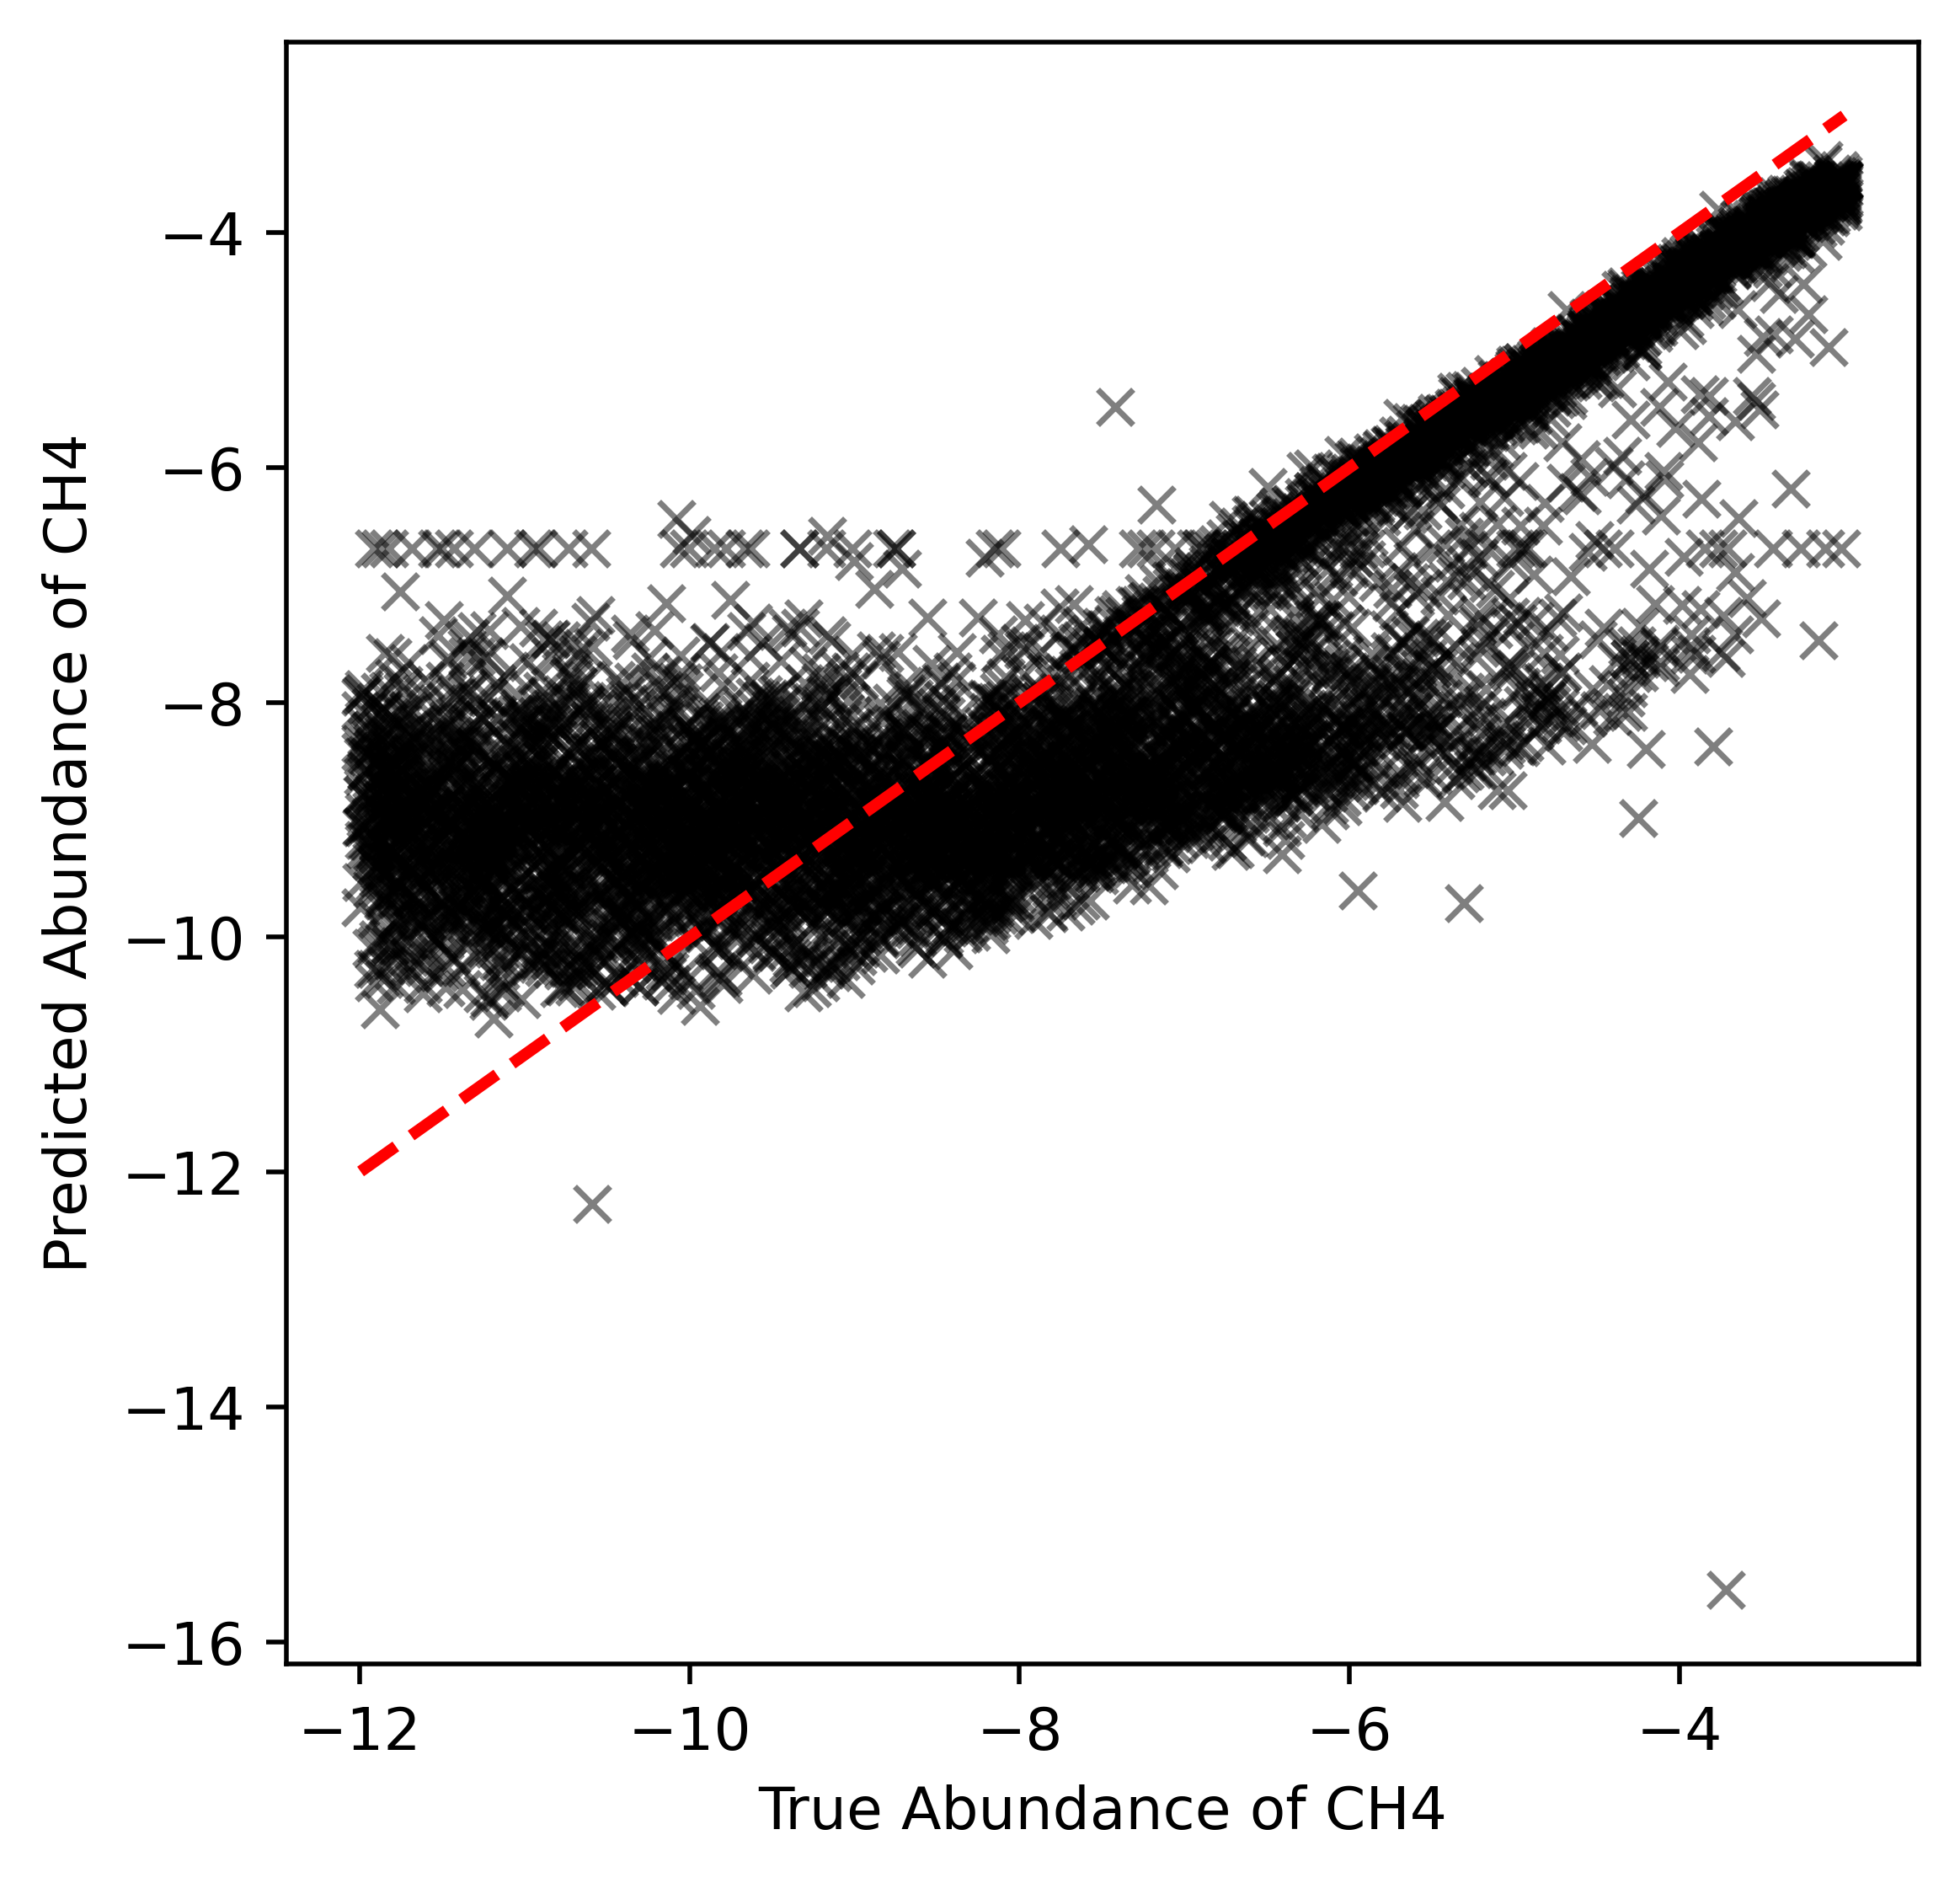

In [ ]:
# i = 0 # for H2O
i = 1 # for CH4
plt.figure(figsize=(5, 5), dpi=500)
plt.plot(test_labels.cpu().numpy()[:, i], test_outputs.cpu().numpy()[:, i],'kx', label=mol_header[i], alpha=0.5)

plt.plot([test_labels.cpu().numpy()[:, i].min(),
        test_labels.cpu().numpy()[:, i].max()],
        [test_labels.cpu().numpy()[:, i].min(),
        test_labels.cpu().numpy()[:, i].max()], 'r--', lw=2)

plt.xlabel(f'True Abundance of {mol_header[index][i]}')
plt.ylabel(f'Predicted Abundance of {mol_header[index][i]}')


# Binned Performance Plot

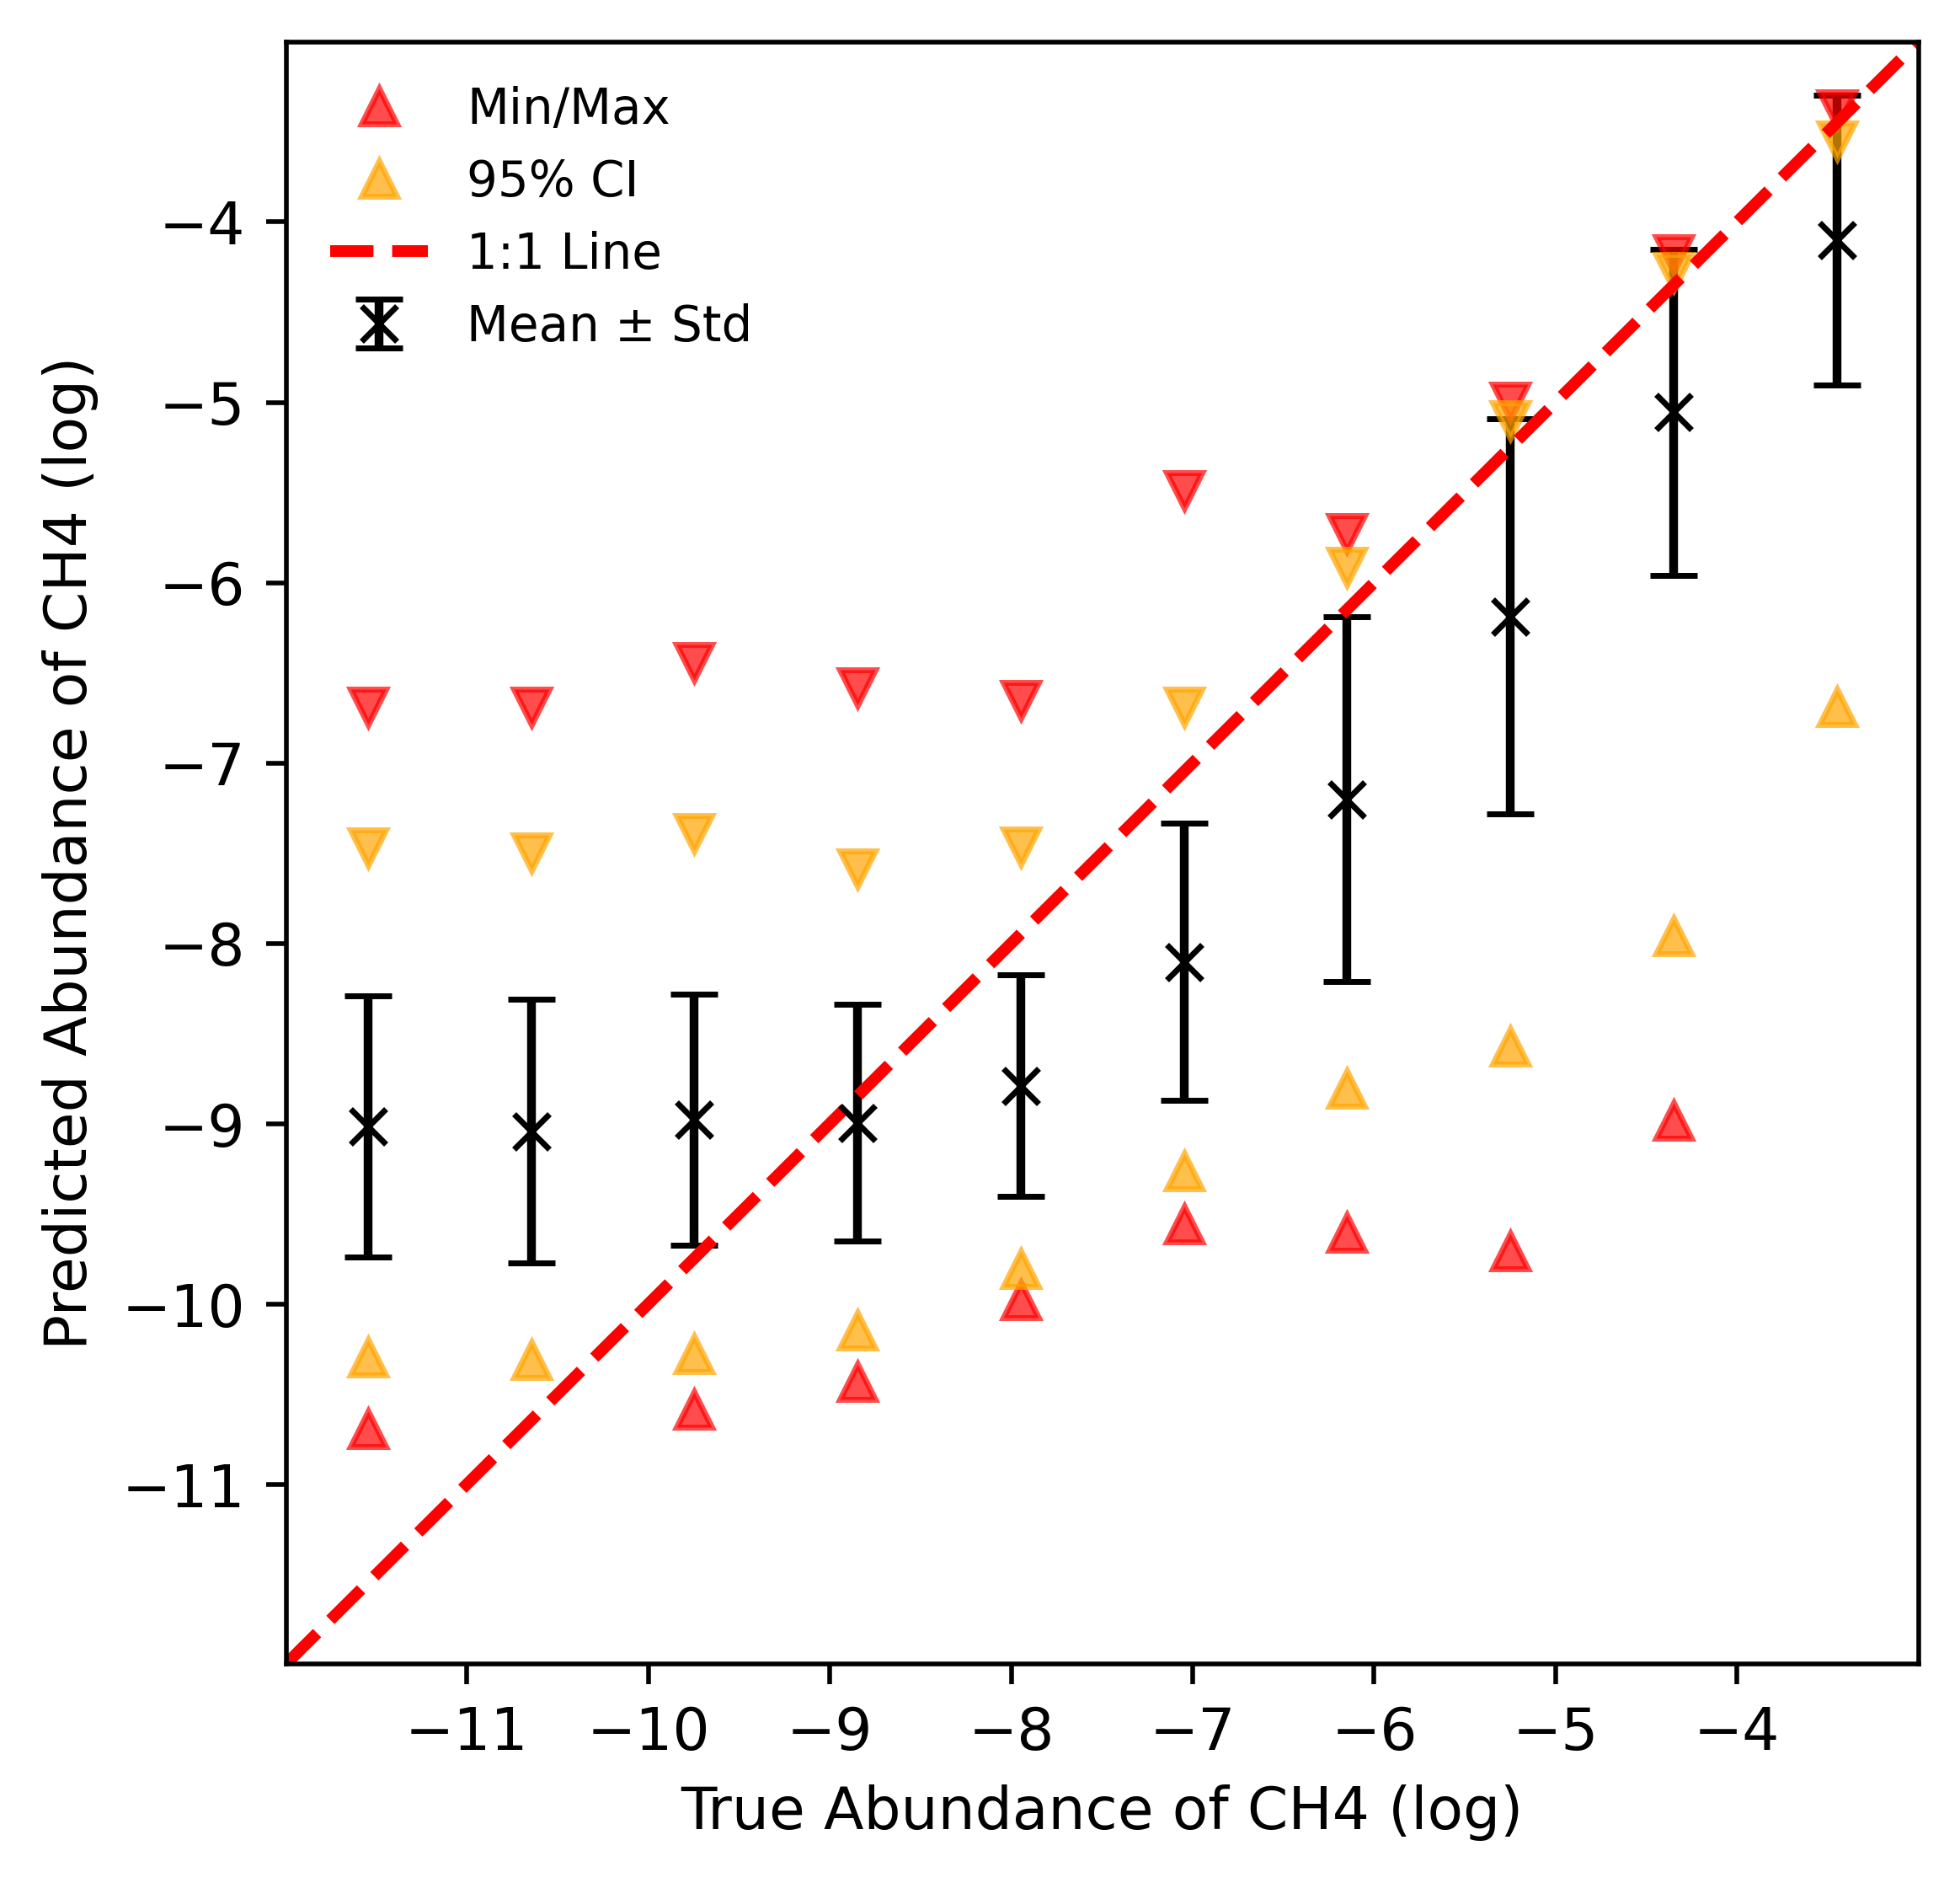

In [60]:
# Extract data
true_values = test_labels.cpu().numpy()[:, i]
predicted_values = test_outputs.cpu().numpy()[:, i]

# Step 1: Bin data along the x-axis
num_bins = 10
bins = np.linspace(true_values.min(), true_values.max(), num_bins + 1)
bin_centers = 0.5 * (bins[:-1] + bins[1:])

# Initialize arrays to store metrics
bin_means, bin_stds, bin_mins, bin_maxs = [], [], [], []
bin_lower_95, bin_upper_95 = [], []

# Step 2: Compute metrics for each bin
for j in range(num_bins):
    bin_mask = (true_values >= bins[j]) & (true_values < bins[j + 1])
    bin_data = predicted_values[bin_mask]
    
    if bin_data.size > 0:
        bin_means.append(bin_data.mean())
        bin_stds.append(bin_data.std())
        bin_mins.append(bin_data.min())
        bin_maxs.append(bin_data.max())
        bin_lower_95.append(np.percentile(bin_data, 2.5))
        bin_upper_95.append(np.percentile(bin_data, 97.5))
    else:
        bin_means.append(np.nan)
        bin_stds.append(np.nan)
        bin_mins.append(np.nan)
        bin_maxs.append(np.nan)
        bin_lower_95.append(np.nan)
        bin_upper_95.append(np.nan)

# Step 3: Plot results
plt.figure(figsize=(5, 5), dpi=500)

# Mean with standard deviation as error bars
plt.errorbar(bin_centers, bin_means, yerr=bin_stds, fmt='x', label='Mean ± Std', capsize=4, color='black')

# Min and Max with 'v' and '^' markers
plt.plot(bin_centers, bin_mins, '^', label='Min/Max', alpha=0.7, color='red')
plt.plot(bin_centers, bin_maxs, 'v', alpha=0.7, color='red')

# 95% confidence interval with different colors
plt.plot(bin_centers, bin_lower_95, '^', label='95% CI', alpha=0.7, color='orange')
plt.plot(bin_centers, bin_upper_95, 'v',  alpha=0.7, color='orange')

# 1:1 reference line
plt.plot([true_values.min(), true_values.max()],
         [true_values.min(), true_values.max()], '--', lw=2, label='1:1 Line', color='red')

# Labels, legend, and show
plt.xlabel(f'True Abundance of {mol_header[index][i]} (log)')
plt.ylabel(f'Predicted Abundance of {mol_header[index][i]} (log)')
plt.legend(loc='upper left', fontsize='small', frameon=False)

plt.xlim(true_values.min(), true_values.max())
plt.ylim(true_values.min(), true_values.max())
plt.show()

